# Latency evaluation of online ASR

## Prerequisites

- Python `3.11` (recommended version)
- install dependencies from `requirements.txt`
- test results in `json` format in a directory

## Load run from JSON

In [69]:
RESULT_DIR = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"
# RESULT_DIR = "../out/2025-05-02_10-50-33_librispeech-pc-test-clean_large-v3-turbo"
# RESULT_DIR = "/home/niko/Downloads/results"

In [70]:
import os
import json

In [71]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith("final.json")]

# get ids from the first part of the filename separated by "_"
file_ids = [f.split("_")[0] for f in files]

def load_element_by_id(file_id):
    with open(os.path.join(RESULT_DIR, file_id + "_final.json"), "r") as f:
        final = json.load(f)

    with open(os.path.join(RESULT_DIR, file_id + "_final_messages.json"), "r") as f:
        final_messages = json.load(f)

    with open(os.path.join(RESULT_DIR, file_id + "_partial.json"), "r") as f:
        partials = json.load(f)
    
    return file_id, final, final_messages, partials

run = [load_element_by_id(file_id) for file_id in file_ids]

## Select an element to analyze

In [72]:
id, final, final_messages, partials = run[0]
print("ID:", id)
print("Final:", len(final))
print("Final messages:", len(final_messages))
print("Partial predictions:", len(partials))

ID: 7127-75946-0000
Final: 496
Final messages: 85
Partial predictions: 309


In [73]:
threshold = 0.3

filtered_partials = []
for entry in partials:
    filtered_result = [
        word for word in entry['result']['result']
        if word['conf'] >= threshold
    ]
    # Strukturell identisch, nur mit gefilterten Wörtern
    filtered_entry = {
        **entry,
        'result': {
            **entry['result'],
            'result': filtered_result
        }
    }
    filtered_partials.append(filtered_entry)

In [74]:
filtered_word_count = sum(len(entry['result']['result']) for entry in filtered_partials)
word_count = sum(len(entry['result']['result']) for entry in partials)
print(word_count)
print(filtered_word_count)

10918
10554


In [75]:
# partials = filtered_partials

In [76]:
for entry in partials:
    last_known_final_time = 0
    for final_message in final_messages:
        if entry['observation_time'] < final_message['observation_time']:
            break
        last_known_final_time = final_message["result"][-1]["end"]
    entry["result"]["unconfirmed"] = [w for w in entry["result"]["result"] if w["end"] > last_known_final_time]

### define partials to use

The two options are: all partials in the content window; only new partial after the last final.

- use `result` for all partials
- use `unconfiremd` for new partials

In [77]:
# PARTIAL_KEY = "result"
PARTIAL_KEY = "unconfirmed"

In [78]:
import re

def is_equal_word(a, b, max_shift=1.5):
    def normalize(w):
        return re.sub(r'[^a-z0-9]', '', w.lower())
    return (
        normalize(a["word"]) == normalize(b["word"])
        # and abs(a["start"] - b["start"]) <= max_shift
        # and abs(a["end"] - b["end"]) <= max_shift
    )

### Aligning partial prediction to final

The idea is to find temporal and semantical aligned matches between the predictions at all timesteps and the resulting final sequence with a two step process.

1. Find temporal aligned matches of same word pairs
2. Find best alignment for incorrect words

Let's assume one timestep.

First I find the index in the final sequence where the alignment process should start. It is defined by the index of the final word, whose predicted start time is greater than the start time of the first word of the partial prediction with an adjustable tolerance.

I then iterate over all words in the prediction.
- If a word match is found in the next position, or any following position with a temporal overlap, accept the alignment immediately and update the index to search from to the alignment position.
- If no word match with temporal overlap is found, store the word with the greatest overlap as potential alignment
- If the predicted word has no temporal overlap with any final word it is considered unaligned

In the second step I want to to confirm the potential alignments
- Final words with an accepted alignments are thrown out of the alignment pool for potential alignments
- A potential alignment is confirmed, if its coresponding final was not thrown out
- One final word can have multiple confirmed potential alignments

In [79]:
from dataclasses import dataclass

temporal_tolerance = 0.5

@dataclass
class WordAlignment:
    partial_timestep: int
    partial_word_index: int
    final_word_index: int

@dataclass
class PredictionAlignment:
    accepted_alignments: list[WordAlignment]
    potential_alignments: list[WordAlignment]
    confirmed_alignments: list[WordAlignment]

def get_search_start_index(partial_alignment: PredictionAlignment, partial, finals):
    if len(partial_alignment.accepted_alignments) == 0:
        search_time_start = partial["start"] - temporal_tolerance
        for f_idx in range(len(finals)):
            final_word = finals[f_idx]
            if final_word["start"] > search_time_start:
                return f_idx
    last_accepted = partial_alignment.accepted_alignments[-1]
    return last_accepted.final_word_index + 1

def get_best_alignment(partial, finals, p_timestep, p_idx, start_index):
    for f_idx in range(start_index, len(finals)):
        final_word = finals[f_idx]
        if is_equal_word(partial, final_word):
            return True, WordAlignment(p_timestep, p_idx, f_idx)
        if final_word["start"] > partial["end"] + temporal_tolerance:
            break
    
    best_alignment = None
    best_alignment_temporal_overlap = 0

    for f_idx in range(start_index, len(finals)):
        final_word = finals[f_idx]
        if final_word["start"] > partial["end"]:
            break
        temporal_overlap = min(partial["end"], final_word["end"]) - max(partial["start"], final_word["start"])
        if temporal_overlap > best_alignment_temporal_overlap:
            best_alignment_temporal_overlap = temporal_overlap
            best_alignment = WordAlignment(p_timestep, p_idx, f_idx)
    
    if best_alignment_temporal_overlap > 0:
        return False, best_alignment
    
    return False, None

def confirm_potential_alignments(partial_alignment: PredictionAlignment):
    used_final_indices = [wa.final_word_index for wa in partial_alignment.accepted_alignments]
    partial_alignment.confirmed_alignments = [wa for wa in partial_alignment.accepted_alignments]
    for wa in partial_alignment.potential_alignments:
        if wa.final_word_index not in used_final_indices:
            partial_alignment.confirmed_alignments.append(wa)

alignments = []

for p_timestep, p in enumerate(partials):
    prediction_alignment = PredictionAlignment([], [], [])
    for p_idx, word in enumerate(p["result"][PARTIAL_KEY]):
        i = get_search_start_index(prediction_alignment, word, final)
        accepted, word_alignment = get_best_alignment(word, final, p_timestep, p_idx, i)
        if accepted:
            prediction_alignment.accepted_alignments.append(word_alignment)
        elif word_alignment is not None:
            prediction_alignment.potential_alignments.append(word_alignment)
    confirm_potential_alignments(prediction_alignment)
    alignments.append(prediction_alignment)

In [80]:
for al in alignments:
    if len(al.potential_alignments) > 0:
        print("\nUnused finals:")
        final_range = range(al.accepted_alignments[0].final_word_index, al.potential_alignments[-1].final_word_index + 1) if len(al.accepted_alignments) > 0 else range(len(final))
        unused_finals = [f for f in final_range if f not in [wa.final_word_index for wa in al.accepted_alignments]]
        print(unused_finals)
        print("\nPotential alignments:")
        for pa in al.potential_alignments:
            print(f"Partial timestep: {pa.partial_timestep}, Partial word index: {pa.partial_word_index}, Final word index: {pa.final_word_index}")


Unused finals:
[5]

Potential alignments:
Partial timestep: 1, Partial word index: 5, Final word index: 5

Unused finals:
[34]

Potential alignments:
Partial timestep: 10, Partial word index: 3, Final word index: 34

Unused finals:
[40, 41]

Potential alignments:
Partial timestep: 15, Partial word index: 6, Final word index: 40
Partial timestep: 15, Partial word index: 14, Final word index: 41

Unused finals:
[45]

Potential alignments:
Partial timestep: 17, Partial word index: 10, Final word index: 45

Unused finals:
[82]

Potential alignments:
Partial timestep: 34, Partial word index: 10, Final word index: 82

Unused finals:
[86]

Potential alignments:
Partial timestep: 35, Partial word index: 14, Final word index: 86

Unused finals:
[]

Potential alignments:
Partial timestep: 56, Partial word index: 0, Final word index: 120

Unused finals:
[124]

Potential alignments:
Partial timestep: 57, Partial word index: 18, Final word index: 122
Partial timestep: 57, Partial word index: 21, F

In [81]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

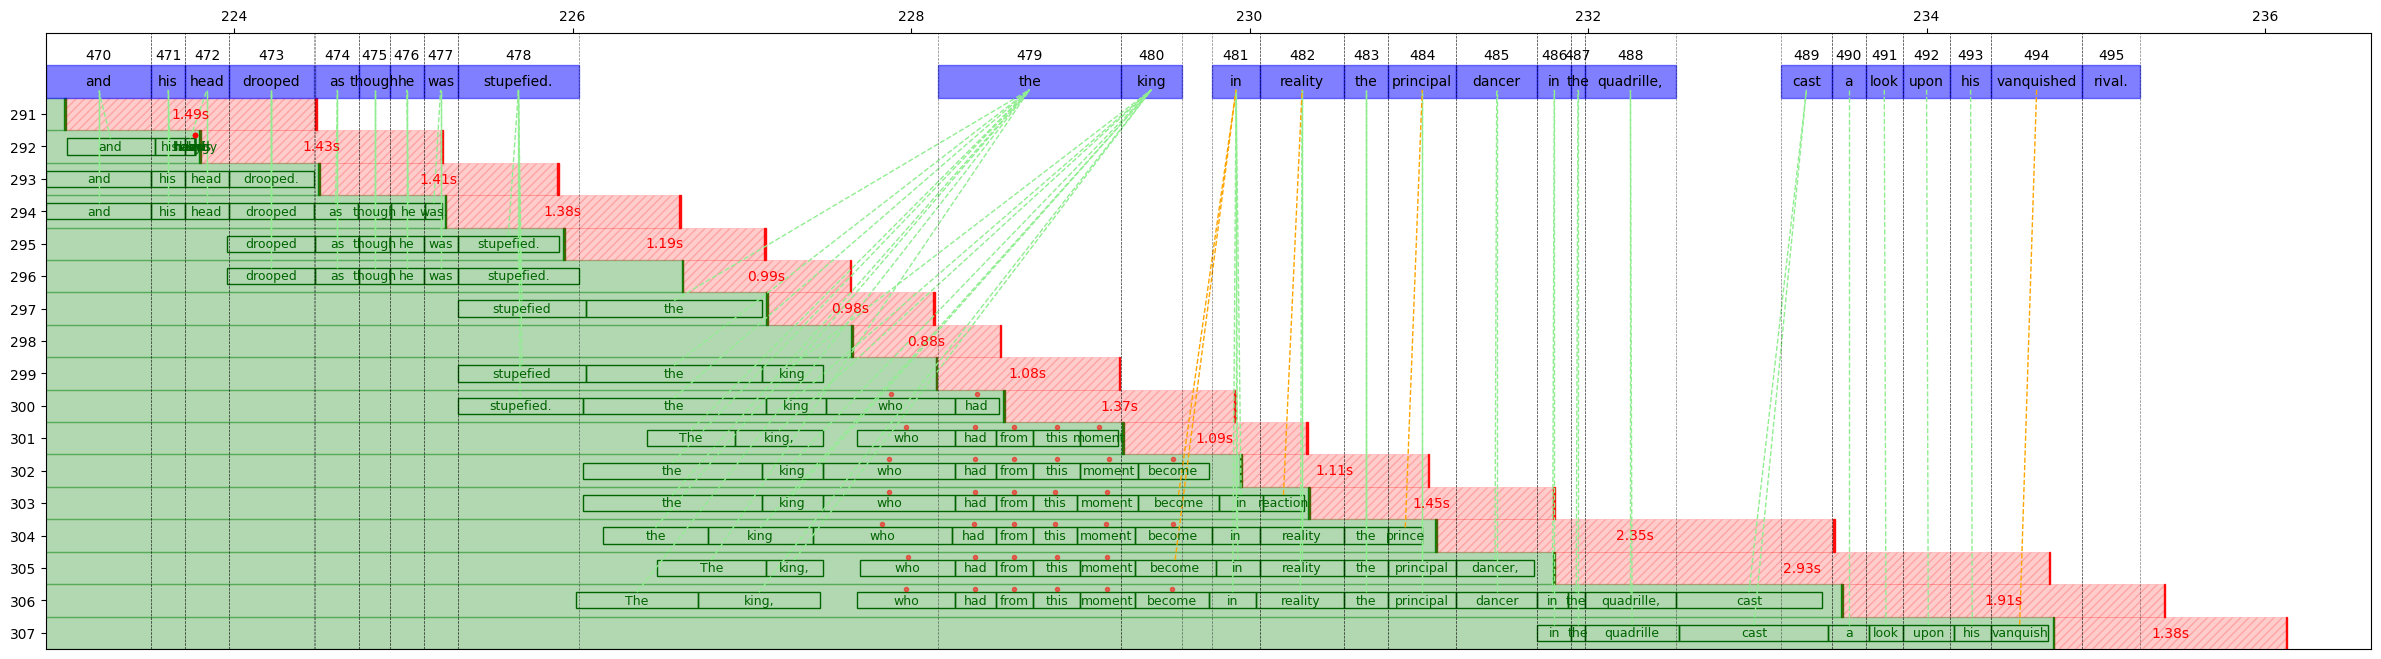

In [82]:
DRAW_CONFIRMED_ALIGNMENTS = False

window_length = 30
window_start = 470
window_end = window_start + window_length

words = final[window_start:window_end]

window_start_t = words[0]["start"]
window_end_t = words[-1]["end"]

# Filter predictions and keep original indices
indexed_predictions = [
    (i, p) for i, p in enumerate(partials)
    if window_start_t <= p["window"][1] and (p["observation_time"] <= window_end_t or p["window"][1] <= window_end_t)
]
indexed_predictions = indexed_predictions[::-1]  # Reverse for display

# Final word mapping (global indices to x/y coordinates)
final_word_positions = {
    i: {
        "x": (word["start"] + word["end"]) / 2,
        "y": len(indexed_predictions) + 0.25  # fixed y for final row
    }
    for i, word in enumerate(final)
}

# Determine max observation time for x-axis limit
max_obs_time = max(window_end_t, max(p["observation_time"] for _, p in indexed_predictions))

fig, ax = plt.subplots(figsize=(30, 8))

for row_index, (original_index, partial) in enumerate(indexed_predictions):
    win_start, win_end = partial["window"]
    obs_time = partial["observation_time"]

    # Green prediction window
    ax.add_patch(Rectangle((win_start, row_index), win_end - win_start, 1, color="green", alpha=0.3))

    # Green bar at window[1]
    marker_width = 0.01
    ax.add_patch(Rectangle((win_end - marker_width / 2, row_index), marker_width, 1, color="green", alpha=0.9))

    # Red delay box
    if obs_time > win_end:
        delay = obs_time - win_end
        ax.add_patch(Rectangle(
            (win_end, row_index), delay, 1,
            color="red", alpha=0.2, hatch='////', linewidth=0.5, fill=True
        ))
        # Delay label
        ax.text(win_end + delay / 2, row_index + 0.5, f"{delay:.2f}s", ha="center", va="center", fontsize=10, color="red")

    # Red bar at observation time
    ax.add_patch(Rectangle((obs_time - marker_width / 2, row_index), marker_width, 1, color="red", alpha=0.9))

    # Word boxes (half-height, dark green frame)
    for word_index, word in enumerate(partial["result"][PARTIAL_KEY]):
        if window_start_t <= word["start"] <= window_end_t:
            ax.add_patch(Rectangle(
                (word["start"], row_index + 0.25), word["end"] - word["start"], 0.5,
                edgecolor="darkgreen", facecolor="none", linewidth=1
            ))
            ax.text((word["start"] + word["end"]) / 2, row_index + 0.5, word["word"],
                    ha="center", va="center", fontsize=9, color="darkgreen")
            
            # Draw alignment line
            wa = None
            accepted = False
            if DRAW_CONFIRMED_ALIGNMENTS:
                for _wa in alignments[original_index].confirmed_alignments:
                    if _wa.partial_word_index == word_index:
                        wa = _wa
                        break
            for _wa in alignments[original_index].accepted_alignments:
                if _wa.partial_word_index == word_index:
                    wa = _wa
                    accepted = True
                    break
            if wa is None and not DRAW_CONFIRMED_ALIGNMENTS:
                for _wa in alignments[original_index].potential_alignments:
                    if _wa.partial_word_index == word_index:
                        wa = _wa
                        break
            if wa is not None:
                if wa.final_word_index in final_word_positions:
                    x0 = (word["start"] + word["end"]) / 2
                    y0 = row_index + 0.75
                    x1 = final_word_positions[wa.final_word_index]["x"]
                    y1 = final_word_positions[wa.final_word_index]["y"]
                    color = "blue" if DRAW_CONFIRMED_ALIGNMENTS else "lightgreen" if accepted else "orange"
                    ax.plot([x0, x1], [y0, y1], color=color, linestyle="dashed", linewidth=1)
            else:
                ax.plot((word["start"] + word["end"]) / 2, row_index + 0.85, "o", color="red", markersize=3, alpha=0.5)
            

# Draw top word layer (blue)
word_y = len(indexed_predictions)
for i, word in enumerate(words):
    start = word["start"]
    end = word["end"]
    ax.add_patch(Rectangle((start, word_y), end - start, 1, color="blue", alpha=0.5))
    ax.text((start + end) / 2, word_y + 0.5, word["word"], ha="center", va="center", fontsize=10)
    ax.text((start + end) / 2, word_y + 1.3, f"{window_start + i}", ha="center", va="center", fontsize=10, color="black")
    ax.axvline(start, color="black", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.axvline(end, color="black", linestyle="--", linewidth=0.5, alpha=0.5)

window_end_t = max_obs_time + 0.5

# Axes setup
ax.set_xlim(window_start_t, window_end_t)
ax.set_ylim(0, word_y + 2)
ax.set_yticks([i + 0.5 for i in range(len(indexed_predictions))])
ax.set_yticklabels([str(idx) for idx, _ in indexed_predictions])
ax.xaxis.tick_top()

plt.show()

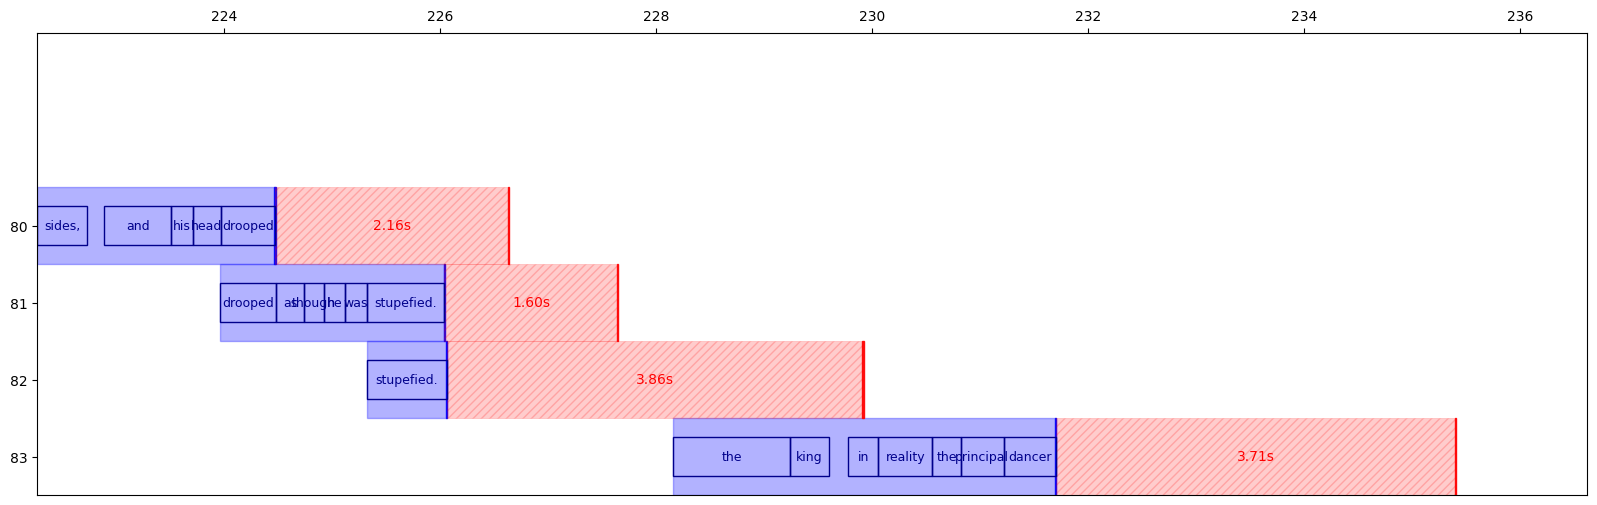

In [83]:
# Alle Messages behalten – keine Filterung
indexed_final_messages = [(i, msg) for i, msg in enumerate(final_messages) if msg["result"] and msg["result"][-1]["end"] >= window_start_t and msg["observation_time"] <= window_end_t]
indexed_final_messages = indexed_final_messages[::-1]

# Fenster automatisch ausdehnen
earliest_start = min(msg["result"][0]["start"] for _, msg in indexed_final_messages)
latest_obs_time = max(msg["observation_time"] for _, msg in indexed_final_messages)

fig, ax = plt.subplots(figsize=(20, 6))

for row_index, (original_index, msg) in enumerate(indexed_final_messages):
    words = msg["result"]
    obs_time = msg["observation_time"]
    start = words[0]["start"]
    end = words[-1]["end"]

    ax.add_patch(Rectangle((start, row_index), end - start, 1, color="blue", alpha=0.3))

    # Green end marker
    marker_width = 0.01
    ax.add_patch(Rectangle((end - marker_width / 2, row_index), marker_width, 1, color="blue", alpha=0.9))

    # Delay box
    if obs_time > end:
        delay = obs_time - end
        ax.add_patch(Rectangle(
            (end, row_index), delay, 1,
            color="red", alpha=0.2, hatch='////', linewidth=0.5, fill=True
        ))
        ax.text(end + delay / 2, row_index + 0.5, f"{delay:.2f}s", ha="center", va="center", fontsize=10, color="red")

    # Observation time marker
    ax.add_patch(Rectangle((obs_time - marker_width / 2, row_index), marker_width, 1, color="red", alpha=0.9))

    # Word boxes
    for word in words:
        ax.add_patch(Rectangle(
            (word["start"], row_index + 0.25), word["end"] - word["start"], 0.5,
            edgecolor="darkblue", facecolor="none", linewidth=1
        ))
        ax.text((word["start"] + word["end"]) / 2, row_index + 0.5, word["word"],
                ha="center", va="center", fontsize=9, color="darkblue")

# Axes setup
ax.set_xlim(earliest_start, window_end_t)
ax.set_ylim(0, len(indexed_final_messages) + 2)
ax.set_yticks([i + 0.5 for i in range(len(indexed_final_messages))])
ax.set_yticklabels([str(idx) for idx, _ in indexed_final_messages])
ax.xaxis.tick_top()

plt.show()

In [84]:
def get_overlap_words(a, b):
    max_overlap = min(len(a), len(b))
    if max_overlap == 0:
        return len(a), -1, 0
    for overlap_size in range(max_overlap, 0, -1):
        for offset in range(len(a) - overlap_size + 1):
            a_suffix = a[len(a)-overlap_size-offset:len(a)-offset]
            b_prefix = b[:overlap_size]
            match = True
            for i in range(overlap_size):
                if not is_equal_word(a_suffix[i], b_prefix[i]):
                    match = False
                    break
            if match:
                idx_a = len(a) - overlap_size - offset
                idx_b = overlap_size - 1
                return idx_a, idx_b, overlap_size
    return len(a), -1, 0

o = []
l = []
num_edits = 0

ps = [{"result": {"result": [{"word": "A"}, {"word": "B"}, {"word": "C"}]}},
      {"result": {"result": [{"word": "B"}, {"word": "C"}, {"word": "D"}, {"word": "E"}]}},
      {"result": {"result": [{"word": "B"}, {"word": "D"}, {"word": "E"}, {"word": "F"}]}},
      {"result": {"result": [{"word": "D"}, {"word": "E"}, {"word": "F"}, {"word": "G"}]}},
      {"result": {"result": [{"word": "E"}, {"word": "F"}, {"word": "G"}, {"word": "H"}]}}]

for p in partials:
    idx_a, idx_b, num_overlap = get_overlap_words(o, p["result"][PARTIAL_KEY])
    if num_overlap > 0:
        new_words = p["result"][PARTIAL_KEY]
        num_delete = len(o) - idx_a - num_overlap
        num_add = len(new_words) - num_overlap
        num_edits += num_delete + num_add
        o = o[:idx_a] + new_words
    else:
        o += p["result"][PARTIAL_KEY]
        num_add = len(p["result"][PARTIAL_KEY])
        num_delete = 0
        num_edits += len(p["result"][PARTIAL_KEY])
    l.append(len(o))
    print("IN:  ", " ".join([w["word"] for w in p["result"][PARTIAL_KEY]]))
    print("OUT: ", " ".join([w["word"] for w in o]))
    print("LEN: ", len(o))
    print("LEN DIFF:", num_add - num_delete)
    print("NEW EDITS:", num_delete + num_add, "\n")

print("Total num edits:", num_edits)
print("len(o):", len(o))
print(l)
print("len(final):", len(final))

IN:   At the conclusion
OUT:  At the conclusion
LEN:  3
LEN DIFF: 3
NEW EDITS: 3 

IN:   At the conclusion of the bankruptcy,
OUT:  At the conclusion of the bankruptcy,
LEN:  6
LEN DIFF: 3
NEW EDITS: 3 

IN:   At the conclusion of the banquet, which was served
OUT:  At the conclusion of the banquet, which was served
LEN:  9
LEN DIFF: 3
NEW EDITS: 5 

IN:   At the conclusion of the banquet, which was served at five o 'clock, Thank you.
OUT:  At the conclusion of the banquet, which was served at five o 'clock, Thank you.
LEN:  15
LEN DIFF: 6
NEW EDITS: 6 

IN:   at five o 'clock, the king entered his
OUT:  At the conclusion of the banquet, which was served at five o 'clock, the king entered his
LEN:  17
LEN DIFF: 2
NEW EDITS: 6 

IN:   at five o 'clock, the king entered his cabinet, where his
OUT:  At the conclusion of the banquet, which was served at five o 'clock, the king entered his cabinet, where his
LEN:  20
LEN DIFF: 3
NEW EDITS: 3 

IN:   cabinet where his tailors were awaiting
O

## Build dataframe

In [85]:
import pandas as pd
import numpy as np

In [86]:
df = pd.DataFrame(partials)
df["window_start"] = df["window"].apply(lambda x: x[0])
df["window_end"] = df["window"].apply(lambda x: x[1])
df["window_duration"] = df["window_end"] - df["window_start"]
df["min_word_start"] = df["result"].apply(lambda x: min([w["start"] for w in x["result"]]))
df["max_word_end"] = df["result"].apply(lambda x: max([w["end"] for w in x["result"]]))
df["observation_delay"] = df["observation_time"] - df["window_end"]
# df["word_count"] = df["result"].apply(lambda x: len(x["result"]))

df.drop(["result", "window"], axis=1, inplace=True)
df[18:25]

,observation_time,window_start,window_end,window_duration,min_word_start,max_word_end,observation_delay
18,20.439135,3.05,18.10,15.05,3.05,18.01,2.339135
19,21.315618,3.05,19.35,16.30,3.05,19.03,1.965618
20,21.867902,5.40,20.45,15.05,19.02,20.42,1.417902
21,22.253732,5.40,21.35,15.95,14.06,21.26,0.903732
22,22.647032,5.40,21.90,16.50,13.78,21.28,0.747032
23,23.040844,7.25,22.30,15.05,16.73,21.27,0.740844
24,23.793808,7.25,22.65,15.40,7.25,22.63,1.143808


In [87]:
df["observation_delay"].max().item()

3.613510267436503

## Timing Metrics

In [88]:
def word_first_correct_response(final, partials, final_index, prediction_alignments: list[PredictionAlignment]):
    '''
    Given the index of a final word, return the first partial response that contains the word
    and the time it was produced.
    '''
    target_word = final[final_index]
    word_start = target_word["start"]

    for prediction_alignment in prediction_alignments:
        alignment = next(filter(lambda wa: wa.final_word_index == final_index, prediction_alignment.accepted_alignments), None)
        if alignment is None:
            continue
        partial = partials[alignment.partial_timestep]
        for w in partial["result"][PARTIAL_KEY]:
            if is_equal_word(w, target_word):
                return {
                    "timestep": alignment.partial_timestep,
                    "observation_time": partial["observation_time"],
                    "latency": partial["observation_time"] - word_start,
                }
    
    return None

def word_first_final_response(final, partials, final_index, prediction_alignments: list[PredictionAlignment]):
    """
    Determine the first partial after which the final word at final_index
    no longer changes and can be considered stable.
    """
    target_word = final[final_index]
    word_start = target_word["start"]


    candidate = None
    last_match_index = -2  # ensure detection of initial match without false "gap"

    for partial_alignment in prediction_alignments:
        alignment = next(filter(lambda wa: wa.final_word_index == final_index, partial_alignment.accepted_alignments), None)
        if alignment is None:
            continue
        partial = partials[alignment.partial_timestep]
        if alignment.partial_timestep > last_match_index + 1:
            candidate = {
                "timestep": alignment.partial_timestep,
                "observation_time": partial["observation_time"],
                "latency": partial["observation_time"] - word_start,
            }
        last_match_index = alignment.partial_timestep
        
    return candidate

wfc = [word_first_correct_response(final, partials, i, alignments) for i in range(len(final))]
print([i for i in range(len(final)) if wfc[i] is None])
wfc_latency = np.array([r["latency"] for r in wfc if r is not None])

wff = [word_first_final_response(final, partials, i, alignments) for i in range(len(final))]
print([i for i in range(len(final)) if wff[i] is None])
wff_latency = np.array([r["latency"] for r in wff if r is not None])

[]
[]


1.9167767621388998


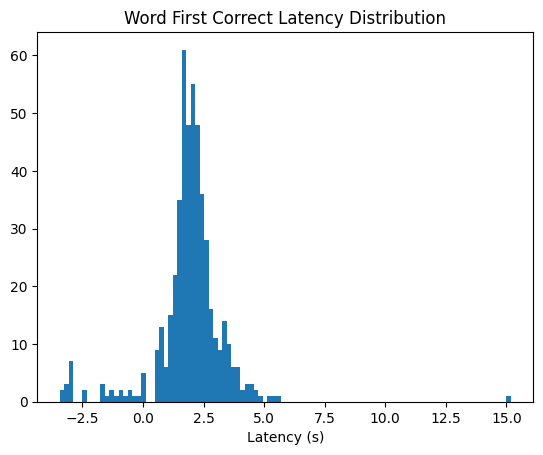

In [89]:
print(wfc_latency.mean().item())
plt.hist(wfc_latency, bins=100, label="Word First Correct")
plt.xlabel("Latency (s)")
plt.title("Word First Correct Latency Distribution")
plt.show()

2.2953603562816296


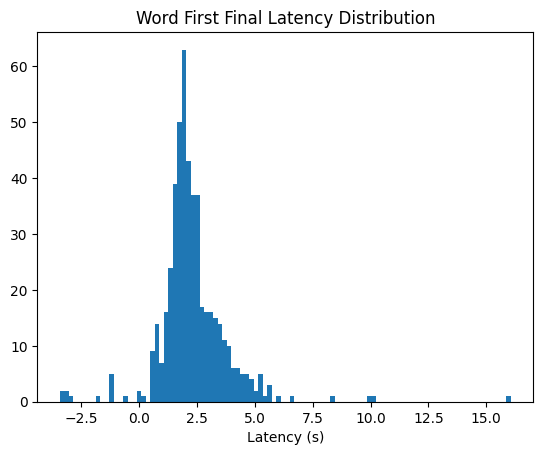

In [90]:
print(wff_latency.mean().item())
plt.hist(wff_latency, bins=100, label="Word First Final")
plt.xlabel("Latency (s)")
plt.title("Word First Final Latency Distribution")
plt.show()